### 此專案來套用所提出之EVCC模型於 NTU RUL 資料

In [2]:
# import used functioons 
#  import tools 
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose
from tensorflow.keras.layers import Add, Concatenate,LSTM, TimeDistributed, MultiHeadAttention, LayerNormalization


from tensorflow.keras.utils import plot_model

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU devices found:")
    for gpu in gpus:
        print(gpu)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed

from rul_features.rul_data_read import read_rul_data

from test_algs.CCAE_ntu_rul import get_initial_files_datalist, CCAE_train
from test_algs.CCAE_ntu_rul import CCAE_model_application, CCAE_model_build_train

import random
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(42)

from rul_features.rul_data_read import read_rul_data


GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Create ccae model

In [3]:
from datetime import datetime
import json


sequence_length=1024
future_length=0
model_folder_path = r'NTU_rul_models\CCAE_models\NTU_RUL'
model_name = f'915_multiscale_CCAE_Base{sequence_length}'
model_path = os.path.join(model_folder_path, model_name)
os.makedirs(model_path, exist_ok=True)

def build_cnn_multi_branch_ae(
    input_dim_list,
    sequence_length,
    condition_dim,
    model_folder_path=None,
    model_name=None,
    iscondition=False,
    # 第一層（分支前）設定
    first_kernel_size=64,      # 第一層 kernel size
    first_layer_filters=None,  # 若為 None，預設用 base_filters
    first_stride=1,            # 第一層 stride（可自訂）
    # 分支 kernels（每個分支全程沿用自己的 k）
    first_branch_kernels=(3, 5, 7),
    # 既有參數
    base_filters=32,
    blocks=3,
    decay=0.5,
    filters_per_block=None,
    # 反捲積（還原第一層 stride）kernel，預設沿用 first_kernel_size
    deconv_kernel_size=None
):
    """
    - Stem：Conv1D(filters=first_layer_filters, kernel_size=first_kernel_size, strides=first_stride, padding='same')
    - Encoder（多分支）：各分支全程用自己的 k；每層 strides=2
    - Bottleneck：Conv1D(k, stride=1)
    - Decoder（多分支）：UpSampling(2)+Conv1D(k, stride=1)
    - Merge 後：只做 1x1 Conv 融合（已移除 3x1 fusion conv）
    - 還原第一層 stride：以「每通道 Conv1DTranspose」(groups=channels, stride=first_stride)
    - **不再強制裁切輸出長度**
    """
    from tensorflow.keras.layers import (
        Input, Concatenate, Conv1D, Dense, UpSampling1D, RepeatVector
    )
    from tensorflow.keras.models import Model

    try:
        from tensorflow.keras.layers import Conv1DTranspose
    except Exception as e:
        raise ImportError(
            "需要 tf.keras.layers.Conv1DTranspose（建議 TF/Keras 2.15+/Keras3）。"
        ) from e

    assert blocks >= 1, "blocks 必須 >= 1"
    assert first_stride >= 1 and int(first_stride) == first_stride, "first_stride 必須為正整數"

    if filters_per_block is not None:
        assert len(filters_per_block) >= blocks, "filters_per_block 長度需 >= blocks"
        f_list = [int(max(1, f)) for f in filters_per_block[:blocks]]
    else:
        f_list = [int(max(1, round(base_filters * (decay ** i)))) for i in range(blocks)]

    if deconv_kernel_size is None:
        deconv_kernel_size = first_kernel_size

    # === Series Inputs ===
    inputs = []
    for idx, input_dim in enumerate(input_dim_list):
        inputs.append(Input(shape=(sequence_length, input_dim), name=f'series_{idx}'))
    series_input = inputs[0] if len(inputs) == 1 else Concatenate(axis=-1, name='series_input_concat')(inputs)

    # === Condition inputs ===
    condition_input_1 = Input(shape=(condition_dim,), name='condition_1')
    condition_input_2 = Input(shape=(condition_dim,), name='condition_2')
    merged_condition = Concatenate(name="merged_condition")([condition_input_1, condition_input_2])

    # === (Optional) repeat condition and concat ===
    x_in = series_input
    if iscondition:
        repeated_condition = RepeatVector(sequence_length, name="cond_repeat")(merged_condition)
        x_in = Concatenate(axis=-1, name='series_with_condition')([x_in, repeated_condition])

    # === Stem：Conv1D(k=first_kernel_size, s=first_stride) ===
    if first_layer_filters is None:
        first_layer_filters = base_filters
        # 基礎分支
    stem = Conv1D(
        filters=first_layer_filters,
        kernel_size=first_kernel_size,
        strides=first_stride,
        padding='same',
        activation='relu',
        name=f'stem_conv_k{first_kernel_size}_s{first_stride}'
    )(x_in)

    # === 每個分支一路用自己的 k；encoder strides=2，decoder 上採樣 2 ===
    def cnn_branch(x, k, name_prefix):
        z = x
        for b in range(blocks):
            z = Conv1D(
                filters=f_list[b], kernel_size=k, strides=1,
                padding='same', activation='relu',
                name=f'{name_prefix}_enc_c{b+1}_k{k}_s2'
            )(z)
            z = MaxPooling1D(pool_size=2, name=f'{name_prefix}_enc_p{b+1}')(z)
            
        # z = Conv1D(
        #     filters=f_list[-1], kernel_size=k, strides=1,
        #     padding='same', activation='relu',
        #     name=f'{name_prefix}_bottleneck_k{k}'
        # )(z)
        
        for b in reversed(range(blocks)):
            z = UpSampling1D(size=2, name=f'{name_prefix}_dec_u{blocks-b}_x2')(z)
            z = Conv1D(
                filters=f_list[b], kernel_size=k, strides=1,
                padding='same', activation='relu',
                name=f'{name_prefix}_dec_c{blocks-b}_k{k}'
            )(z)
        return z

    branch_outputs = [cnn_branch(stem, k, name_prefix=f'branch_k{k}') for k in first_branch_kernels]

    merged = Concatenate(axis=-1, name='decoder_branches_concat')(branch_outputs)

    # === 只保留 1x1 融合層 ===
    fuse_width = max(f_list[0], first_layer_filters, base_filters)
    fused = Conv1D(fuse_width, 1, padding='same', activation='relu', name='fusion_conv1x1')(merged)

    # === 每通道 Conv1DTranspose 還原第一層 stride ===
    if first_stride > 1:
        fused = Conv1DTranspose(
            filters=fuse_width,
            kernel_size=deconv_kernel_size,
            strides=first_stride,
            padding='same',
            activation='linear',
            groups=fuse_width,  # depthwise transpose
            name=f'undo_first_stride_deconv_dw_k{deconv_kernel_size}_s{first_stride}'
        )(fused)

    # === Output per channel ===
    output_list = [Dense(dim, activation='linear', name=f'output_{idx}')(fused)
                   for idx, dim in enumerate(input_dim_list)]

    model = Model(
        inputs=inputs + [condition_input_1, condition_input_2],
        outputs=output_list,
        name=(f'CNN_MultiBranch_AE_{series_input.shape[-1]}in_{len(output_list)}out_'
              f'b{blocks}_stemK{first_kernel_size}_s{first_stride}_deconvK{deconv_kernel_size}_'
              f'K{len(first_branch_kernels)}_perBranchK_fuse1x1_noCrop')
    )
    return model


WD_length=64
WD_stride=4
branch_kernels=(3, 5, 7)
enc_depth=3
encoder_decay_rate=0.5

# VI model rul2 based 
my_model_V_in_I_out_PEWC_rul2=  build_cnn_multi_branch_ae(
    input_dim_list=[2],
    sequence_length=sequence_length,
    condition_dim=1,    
    first_kernel_size=WD_length,        
    first_stride=WD_stride,           # 可設定：第一層 stride
    iscondition=False,           # 是否使用條件向量
    first_branch_kernels=branch_kernels,    # 三個分支的卷積核大小
    base_filters=32,            # 每個分支第一層卷積的濾波器數, 有條件模型壓縮量較大所以filter 數量兩倍
    blocks=enc_depth,                   # 編碼層數
    decay=encoder_decay_rate                   # 每層濾波器數的衰減率
)
metadata = {
    "model_name": model_name+'_nocond_VI',
    "sequence_length": sequence_length,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_VI_metadata_rul2.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

# II model rul2 based 
my_model_I_in_I_out_PEWC_rul2 =  build_cnn_multi_branch_ae(
    input_dim_list=[2],
    sequence_length=sequence_length,
    condition_dim=1,    
    first_kernel_size=WD_length,        
    first_stride=WD_stride,           # 可設定：第一層 stride
    iscondition=False,           # 是否使用條件向量
    first_branch_kernels=branch_kernels,    # 三個分支的卷積核大小
    base_filters=32,            # 每個分支第一層卷積的濾波器數, 有條件模型壓縮量較大所以filter 數量兩倍
    blocks=enc_depth,                   # 編碼層數
    decay=encoder_decay_rate                   # 每層濾波器數的衰減率
)
metadata = {
    "model_name": model_name+'_I',
    "sequence_length": sequence_length,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_I_metadata_rul2.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)
    
# VI model rul2 based 
my_model_V_in_I_out_PEWC_rul5=  build_cnn_multi_branch_ae(
    input_dim_list=[2],
    sequence_length=sequence_length,
    condition_dim=1,    
    first_kernel_size=WD_length,        
    first_stride=WD_stride,           # 可設定：第一層 stride
    iscondition=False,           # 是否使用條件向量
    first_branch_kernels=branch_kernels,    # 三個分支的卷積核大小
    base_filters=32,            # 每個分支第一層卷積的濾波器數, 有條件模型壓縮量較大所以filter 數量兩倍
    blocks=enc_depth,                   # 編碼層數
    decay=encoder_decay_rate                   # 每層濾波器數的衰減率
)
metadata = {
    "model_name": model_name+'_nocond_VI',
    "sequence_length": sequence_length,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_VI_metadata_rul5.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)
# II model rul5 based
my_model_I_in_I_out_PEWC_rul5 =  build_cnn_multi_branch_ae(
    input_dim_list=[2],
    sequence_length=sequence_length,
    condition_dim=1,    
    first_kernel_size=WD_length,        
    first_stride=WD_stride,           # 可設定：第一層 stride
    iscondition=False,           # 是否使用條件向量
    first_branch_kernels=branch_kernels,    # 三個分支的卷積核大小
    base_filters=32,            # 每個分支第一層卷積的濾波器數, 有條件模型壓縮量較大所以filter 數量兩倍
    blocks=enc_depth,                   # 編碼層數
    decay=encoder_decay_rate                   # 每層濾波器數的衰減率
)
metadata = {
    "model_name": model_name+'_I',
    "sequence_length": sequence_length,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_I_metadata_rul5.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)
    




print("All Model saved and loaded successfully.")
print(f"my_model_V_in_V_out parameters: {my_model_V_in_I_out_PEWC_rul2.count_params()}")
print(f"my_model_I_in_I_out parameters: {my_model_I_in_I_out_PEWC_rul2.count_params()}")

All Model saved and loaded successfully.
my_model_V_in_V_out parameters: 108722
my_model_I_in_I_out parameters: 108722


資料前處理

In [4]:
import re
import shutil
from sklearn.model_selection import train_test_split
from test_algs.CCAE_ntu_rul import data_augmentation
from scipy.signal import butter, filtfilt
import re
def extract_number(path):
    # 用正則抓取 parquet 前面的數字
    match = re.search(r'_(\d+)\.parquet$', path)
    return int(match.group(1)) if match else -1

def data_random_augmentation(raw_data, sequence_length, augmen_sample_number=1000, future_length=64):
    
    # 增加一個回傳時間步長，作為下一點訓練資料使用
    sequence_length=sequence_length+future_length  
    
    # 從 原始資料df 中隨機選取augmen_sample_number 個起始點為sequence_length長度的序列樣本。
    # raw_data 為 n,4 的序列資料，每一行分別為 voltage alpha, voltage beta, current alpha, current beta
    #資料增強倍率
    max_augment_factor = len(raw_data)-sequence_length+1
    # 最多增強樣本數不能超過資料長度除以序列長度
    augmen_sample_number = min(augmen_sample_number, max_augment_factor)


    # 初始化一個空的列表來存放提取出的樣本數據  
    samples_list = []

    # 隨機選取 augmen_sample_number 個起始點
    start_indices = np.random.choice(len(raw_data) - sequence_length + 1, augmen_sample_number, replace=False)
    samples_list = [ raw_data[start_idx:start_idx+sequence_length][:] for start_idx in start_indices]

    # 將收集到的所有樣本轉換成 NumPy 多維陣列
    final_data = np.array(samples_list)
    
    return final_data

# 均勻切分函式 (驗證用)
def data_interval_augmentation(raw_data, sequence_length, augmen_sample_number=5, future_length=64):
    """
    以等距起點切分固定長度序列（不隨機），並可指定切分數量。
    
    raw_data: shape (n, d)
    sequence_length: 視窗長度（滑動窗大小）
    num_samples: 期望切分的樣本數（會自動上限為最大可切數）

    回傳:
        final_data: shape (num_samples_eff, sequence_length, d)
    """
    n = len(raw_data)
    if sequence_length <= 0:
        raise ValueError("sequence_length 必須為正整數")
    if n < sequence_length:
        raise ValueError("資料長度不足以切出任何序列樣本")
    if augmen_sample_number <= 0:
        raise ValueError("num_samples 必須為正整數")

    # 最大可切的起點數（= 可切的樣本上限）
    max_possible = n - sequence_length + 1

    # 若要求超過上限，截到上限
    num_samples_eff = min(augmen_sample_number, max_possible)

    # 等距產生起點（含 0 與 max_possible-1）
    if num_samples_eff == 1:
        start_indices = np.array([0], dtype=int)
    else:
        step = (max_possible - 1) / (num_samples_eff - 1)
        start_indices = np.round(np.arange(num_samples_eff) * step).astype(int)
        start_indices = np.clip(start_indices, 0, max_possible - 1)

    # 依起點切片
    samples_list = [raw_data[s:s + sequence_length] for s in start_indices]
    final_data = np.array(samples_list)

    return final_data

def split_train_val_files(Normal_subfolders, test_size=0.2):
    train_files = []
    val_files = []
    for folder in Normal_subfolders:
        parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
        # 如果資料夾中有多於一個 parquet 檔案，則隨機進行分割
        if len(parquet_files) > 1:
            train, val = train_test_split(parquet_files, test_size=test_size)
            train_files.extend(train)
            val_files.extend(val)
        elif len(parquet_files) == 1:
            train_files.extend(parquet_files)
    return train_files, val_files

def copy_val_files_to_validation(val_files, validation_folder_path):
    for file_path in val_files:
        # 取得原始檔案所在的資料夾名稱 (例如 "class1", "class2")
        class_name = os.path.basename(os.path.dirname(file_path))
        # 在 validation 資料夾下建立對應子資料夾
        class_folder = os.path.join(validation_folder_path, class_name)
        os.makedirs(class_folder, exist_ok=True)
        # 複製檔案到對應子資料夾
        shutil.copy(file_path, class_folder)

def estimate_torque(data_read, speed_v=3530, debug=False):

    """
    Estimate the motor torque based on voltage and current inputs.
    :param v_a_raw: Voltage alpha component
    :param v_b_raw: Voltage beta component
    :param i_alpha: Current alpha component
    :param i_beta: Current beta component
    :param speed_v: Motor speed in rpm (default: 900)
    :param debug: Boolean flag to enable debugging plots (default: False)
    :return: Estimated torque array
    """

    v_a_raw = np.array(data_read["Voltage alpha"])
    v_c_raw = np.array(data_read["Voltage beta"])
    i_alpha = np.array(data_read["Current alpha"])
    i_beta  = np.array(data_read["Current beta"])

    # offset calibration
    v_a_raw = v_a_raw - np.mean(v_a_raw)
    v_c_raw = v_c_raw - np.mean(v_c_raw)
    i_alpha = i_alpha - np.mean(i_alpha)
    i_beta = i_beta - np.mean(i_beta)


   
    # Preprocess the voltage data, transform the data to alpha-beta frame
    v_alpha = v_a_raw
    v_beta = (-v_c_raw + v_a_raw - v_c_raw) / np.sqrt(3)
    
    # back to wrong abc 
    v_a=v_alpha
    v_b=-v_alpha / 2 + v_beta * np.sqrt(3) / 2
    v_c=-v_alpha / 2 - v_beta * np.sqrt(3) / 2
    
    i_ab= i_alpha
    i_bc= -i_alpha / 2 + i_beta * np.sqrt(3) / 2
    i_ca= -i_alpha / 2 - i_beta * np.sqrt(3) / 2



    def delta_to_y_current(I_ab, I_bc, I_ca):
        """
        將 delta 接法三相電流轉換為虛擬 Y 接法電流。
        參數:
            I_ab, I_bc, I_ca: np.array 或 float，a->b, b->c, c->a 的相電流
        回傳:
            i_a, i_b, i_c: Y 等效相電流
        """
        i_a = I_ab - I_ca
        i_b = I_bc - I_ab
        i_c = I_ca - I_bc
        return i_a, i_b, i_c

    def delta_to_y_voltage(V_ab, V_bc, V_ca):
        """
        將 delta 接法三相電壓轉換為虛擬 Y 接法電壓。
        參數:
            V_ab, V_bc, V_ca: np.array 或 float，ab, bc, ca 的相間電壓
        回傳:
            v_a, v_b, v_c: Y 等效相電壓
        """
        v_a = (2/3)*V_ab - (1/3)*V_bc - (1/3)*V_ca
        v_b = (2/3)*V_bc - (1/3)*V_ca - (1/3)*V_ab
        v_c = (2/3)*V_ca - (1/3)*V_ab - (1/3)*V_bc
        return v_a, v_b, v_c

    def clarke_transform(a, b, c):
        """
        Clarke Transform: 將三相轉換成 alpha-beta 軸
        參數:
            a, b, c: Y 相電壓或電流
        回傳:
            alpha, beta
        """
        T = (2/3) * np.array([
            [1, -0.5, -0.5],
            [0,  np.sqrt(3)/2, -np.sqrt(3)/2]
        ])
        abc = np.array([a, b, c])
        alpha_beta = T @ abc.squeeze()
        return alpha_beta[0], alpha_beta[1]

    def delta_to_clarke(I_ab, I_bc, I_ca, V_ab, V_bc, V_ca):
        """
        將 delta 接法電壓與電流轉換為 Clarke alpha-beta 表示
        參數:
            I_ab, I_bc, I_ca: 相電流
            V_ab, V_bc, V_ca: 相電壓
        回傳:
            I_alpha, I_beta, V_alpha, V_beta
        """
        i_a, i_b, i_c = delta_to_y_current(I_ab, I_bc, I_ca)
        v_a, v_b, v_c = delta_to_y_voltage(V_ab, V_bc, V_ca)
        I_alpha, I_beta = clarke_transform(i_a, i_b, i_c)
        V_alpha, V_beta = clarke_transform(v_a, v_b, v_c)
        return I_alpha, I_beta, V_alpha, V_beta

    i_alpha, i_beta, v_alpha, v_beta = delta_to_clarke(i_ab, i_bc, i_ca, (v_a-v_b), ( (v_b-v_c)), (v_c-v_a))
    
    class EMF:
        def __init__(self):
            self.Alpha = 0.0
            self.Beta = 0.0
            self.Alpha_last = 0.0
            self.Beta_last = 0.0
            self.Alpha_LPF = 0.0
            self.Beta_LPF = 0.0
            self.Alpha_LPF_last = 0.0
            self.Beta_LPF_last = 0.0

    def emf_to_lpf(sampling_time, lpf_radius, emf_obj):
        lpf_radius_t = lpf_radius * sampling_time
        emf_coef1 = sampling_time / (lpf_radius_t + 2)
        emf_coef2 = (lpf_radius_t - 2) / (lpf_radius_t + 2)

        emf_obj.Alpha_LPF = emf_coef1 * (emf_obj.Alpha_last + emf_obj.Alpha) - emf_coef2 * emf_obj.Alpha_LPF_last
        emf_obj.Beta_LPF = emf_coef1 * (emf_obj.Beta_last + emf_obj.Beta) - emf_coef2 * emf_obj.Beta_LPF_last

        emf_obj.Alpha_last = emf_obj.Alpha
        emf_obj.Beta_last = emf_obj.Beta

        emf_obj.Alpha_LPF_last = emf_obj.Alpha_LPF
        emf_obj.Beta_LPF_last = emf_obj.Beta_LPF

    def flux_comp(omega_e, lpf_radius):
        if np.abs(omega_e) < 1:
            mag_comp = 1.0
        else:
            mag_comp = np.abs(omega_e) / np.sqrt(omega_e ** 2 + lpf_radius ** 2)

        phase_comp = -57.29578 * np.arctan2(lpf_radius, omega_e) / 360  # Degree to radians conversion

        return mag_comp, phase_comp

    # Compute necessary parameters
    fs = 10000  # Sampling rate
    flux_rs = 0.06  # Motor stator resistance
    tsim = 1 / fs  # Time step

    we = (speed_v / 60) * (np.pi * 2) # electrical angular velocity
    coef = 0.2
    cross_freq = 15.0

    intgr_bw_f = max((we / (np.pi * 2)) * coef, cross_freq)
    fast_wc = intgr_bw_f * (np.pi * 2)

    # Process each time step
    emf1 = EMF()
    alpha_lpf_values, beta_lpf_values = [], []
    alpha_raw_values, beta_raw_values = [], []

    for va, vb, ia, ib in zip(v_alpha, v_beta, i_alpha, i_beta):
        emf1.Alpha = va - (ia * flux_rs)
        emf1.Beta = vb - (ib * flux_rs)
        alpha_raw_values.append(emf1.Alpha)
        beta_raw_values.append(emf1.Beta)
        emf_to_lpf(tsim, fast_wc, emf1)
        alpha_lpf_values.append(emf1.Alpha_LPF)
        beta_lpf_values.append(emf1.Beta_LPF)

    # Flux compensation
    mag_comp2, phase_comp2 = flux_comp(we, fast_wc)

    # Apply phase and magnitude compensation
    alpha_compensated_values, beta_compensated_values = [], []
    for alpha, beta in zip(alpha_lpf_values, beta_lpf_values):
        ds = alpha * mag_comp2
        qs = beta * mag_comp2
        angle = phase_comp2
        sine, cosine = np.sin(angle), np.cos(angle)
        alpha_transformed = ds * cosine - qs * sine
        beta_transformed = qs * cosine + ds * sine
        alpha_compensated_values.append(alpha_transformed)
        beta_compensated_values.append(beta_transformed)

    # Torque estimation
    torque_v = 1.5 * 2 * ((np.array(alpha_compensated_values) * i_beta) - (np.array(beta_compensated_values) * i_alpha))
    torque_avg = np.mean(np.abs(torque_v[-500:]))
    # Power and efficiency estimation
    Power_M= torque_avg*speed_v*2*np.pi/60
    Power_E = 1.5*np.mean((v_alpha * i_alpha + v_beta * i_beta))
    efficiency = Power_M / Power_E * 100
    power_sts = {
        'Power_M': Power_M,
        'Power_E': Power_E,
        'Efficiency': efficiency,
        'Efficiency_alarm': int(efficiency < 90)
    }

    if debug :
        date_time=pd.to_datetime(data_read["Unix Time"], unit='s').strftime('%Y-%m-%d %H:%M:%S')

        print("Estimated Torque:", np.mean(torque_v[-Motor_global_vars.data_length:]))
        # print result
        for key, value in power_sts.items():
            print(f"{key}: {value}")
        time = np.arange(len(v_alpha)) * tsim

        # plot the flux values
        plt.figure(figsize=(10, 5))
        plt.plot(time, alpha_compensated_values, label='Flux Alpha')
        plt.plot(time, beta_compensated_values, label='Flux Beta ')
        plt.xlabel('Time (s)')
        plt.ylabel('Flux Values')
        plt.legend()
        plt.title('Flux Values'+date_time)
        plt.grid()
        plt.show(block=False)

        # plot the voltage values
        plt.figure(figsize=(10, 5))
        plt.plot(time, v_alpha, label='Voltage Beta (raw)')
        plt.plot(time, v_beta, label='Voltage Beta (raw)')
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage Values')
        plt.legend()
        plt.title('Voltage Values')
        plt.grid()
        plt.show(block=False)

        # plot the current values
        plt.figure(figsize=(10, 5))
        plt.plot(time, i_alpha, label='Current Alpha (raw)')
        plt.plot(time, i_beta, label='Current Beta (raw)')
        plt.xlabel('Time (s)')
        plt.ylabel('Current Values')
        plt.legend()
        plt.title('Current Values')
        plt.grid()
        plt.show(block=False)

        # plot the EMF values
        plt.figure(figsize=(10, 5))
        plt.plot(time, alpha_raw_values, label='EMF Alpha (raw)')
        plt.plot(time, beta_raw_values, label='EMF Beta (raw)')
        plt.xlabel('Time (s)')
        plt.ylabel('EMF Values')
        plt.legend()
        plt.title('EMF Values')
        plt.grid()
        plt.show(block=False)

        # plot torque estimation
        plt.figure(figsize=(10, 5))
        plt.plot(time, torque_v, label='Torque (Voltage Model)')
        if len(torque_v) > 2500:
            plt.plot(time[2250:2500], torque_v[2250:2500], label='monitored torque region', color='red')
            torque_avg=np.mean(torque_v[2250:2500])
        else:
            plt.plot(time[-500:], torque_v[-500:], label='monitored torque region', color='red')
            torque_avg=np.mean(torque_v[-500:])
            
        plt.axhline(y=torque_avg, color='k', linestyle='--', label='Averaged torque')
        plt.xlabel('Time (s)')
        plt.ylabel('Torque (N.m)')
        plt.legend()
        plt.title(f'Torque Estimation :{torque_avg:.2f} (N.m)')
        plt.grid()
        plt.show(block=False)

        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('EMF Alpha (Raw)', color='tab:blue')
        ax1.plot(time, alpha_raw_values, label='EMF Alpha (Raw)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.set_ylabel('EMF Alpha (Filtered)', color='tab:red')
        # ax2.plot(time, alpha_lpf_values, label='EMF Alpha (Filtered)', color='tab:red')
        ax2.plot(time, alpha_compensated_values, label='EMF Alpha (Compensated)', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        ax2.legend(loc='upper right')

        plt.title('EMF Alpha - Raw vs Filtered')
        plt.grid()
        plt.show(block=False)
    # return the torque value and the estimated flux
    return torque_v, alpha_compensated_values, beta_compensated_values, v_alpha, v_beta, power_sts
# rul_dataset_path=r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0710_3000_10_1.0v_3"
# rul_dataset_path=r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0722_1800_10p_1.0v_1_2"
rul_dataset_path=r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0722_1800_10p_1.0v_1_1"
# rul_dataset_path=r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0718_1200_15p_1.0v_1"


# 取出 rul2_dataset_path 中的所有 file 名稱
rul2_files = [f for f in os.listdir(rul_dataset_path) if os.path.isfile(os.path.join(rul_dataset_path, f))]
# 將 rul2_dataset_path 路徑加回 rul2_files，得到完整路徑列表
rul2_files = [os.path.join(rul_dataset_path, f) for f in rul2_files]
rul2_files = sorted(rul2_files, key=extract_number)
print(rul2_files[0:10])

print(f'rul2 file number: {len(rul2_files)}')


['D:\\OneDrive\\RUL HI Reasearch Result\\Data_sets\\NTU_RUL_v2_data\\Acc_life_test_data\\Uncategorized_Data\\0722_1800_10p_1.0v_1_1\\915_multiscale_CCAE_Base1024.keras', 'D:\\OneDrive\\RUL HI Reasearch Result\\Data_sets\\NTU_RUL_v2_data\\Acc_life_test_data\\Uncategorized_Data\\0722_1800_10p_1.0v_1_1\\915_multiscale_CCAE_Base1024_VI_metadata_rul2.json', 'D:\\OneDrive\\RUL HI Reasearch Result\\Data_sets\\NTU_RUL_v2_data\\Acc_life_test_data\\Uncategorized_Data\\0722_1800_10p_1.0v_1_1\\rul_reconstruction_MSE.svg', 'D:\\OneDrive\\RUL HI Reasearch Result\\Data_sets\\NTU_RUL_v2_data\\Acc_life_test_data\\Uncategorized_Data\\0722_1800_10p_1.0v_1_1\\RUL_Data_3_24.parquet', 'D:\\OneDrive\\RUL HI Reasearch Result\\Data_sets\\NTU_RUL_v2_data\\Acc_life_test_data\\Uncategorized_Data\\0722_1800_10p_1.0v_1_1\\RUL_Data_3_25.parquet', 'D:\\OneDrive\\RUL HI Reasearch Result\\Data_sets\\NTU_RUL_v2_data\\Acc_life_test_data\\Uncategorized_Data\\0722_1800_10p_1.0v_1_1\\RUL_Data_3_26.parquet', 'D:\\OneDrive\\R

In [6]:

training_file_numbers=40 # 取前20個做為訓練使用
# train_files, val_files = train_test_split(rul2_files[0:training_file_numbers], test_size=0.2)
train_files=rul2_files[0:training_file_numbers]
augmen_sample_number=500
def get_augment_data_from_files(files, augmen_sample_number=500):
    #進行資料增強
    train_signals=[] # vi signals alpha beta 
    train_signals_normalized=[]
    torque_array=[]
                
    for file_path in files:
        if os.path.exists(file_path):
            # read the data
            df = read_rul_data(file_path)
            
            voltage_alpha = np.array(df["Voltage alpha downsample"]).squeeze()
            voltage_beta = np.array(df["Voltage beta downsample"]).squeeze()
            current_alpha = np.array(df["Current alpha downsample"]).squeeze()
            current_beta = np.array(df["Current beta downsample"]).squeeze()
                
            torque = (df["Torque avg"]) 
            speed = (df["Speed"][0])
            
            # 合併測試資料至訓練維度 shape=(,4000,dim)
            temp_train_signals=[voltage_alpha, 
                                        voltage_beta,
                                        current_alpha,
                                        current_beta]
            
            temp_train_signals_normalized = []
            
            # 將數據標準化（均值為 0，標準差為 1）
            for signal in temp_train_signals:
                mean = np.mean(signal)
                std = np.std(signal)
                # 避免除以零的狀況（std == 0）
                if std == 0:
                    standardized = np.zeros_like(signal)
                else:
                    standardized = (signal - mean) / std
                temp_train_signals_normalized.append(standardized)
                    

            temp_train_signals = np.stack(temp_train_signals, axis=1)
            temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
            
            temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
            temp_train_signals_normalized_augmented = data_random_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
            # 加入 train_input_signals
            train_signals.append(temp_train_input_signals_augmented)
            train_signals_normalized.append(temp_train_signals_normalized_augmented)
            torque_array.append(np.ones(augmen_sample_number) * torque)
            
        else:
            print(f"File {file_path} does not exist.")
            
    train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
    train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
    torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)

    # 隨機打亂訓練資料
    indices = np.random.permutation(train_signals.shape[0])
    train_signals = train_signals[indices]
    train_input_signals = train_signals[:, :sequence_length, :]  # 取前 sequence_length 個
    # 正規化訓練資料
    train_signals_normalized = train_signals_normalized[indices]
    train_input_signals_normalized = train_signals_normalized[:, :sequence_length, :]
    torque_array = torque_array[indices]
    torque_array = torque_array.reshape(-1, 1)      # 將 torque_array 轉為 n, 1 batch 輸入狀態標籤

    # 訓練所需資料 (模型參考輸入)
    past_voltages=train_input_signals[:, :, 0:2]
    past_currents=train_input_signals[:, :, 2:4]
    # 正規畫資料
    past_voltages_normalized=train_input_signals_normalized[:, :, 0:2]
    past_currents_normalized=train_input_signals_normalized[:, :, 2:4] 
        # 將資料儲存到字典中
            
    augment_data = {
        "input_signals": train_input_signals[:, :sequence_length, :],                         # 取前 sequence_length 個時間步長
        "input_signals_normalized": train_input_signals_normalized[:, :sequence_length, :],   # 取前 sequence_length 個時間步長
        "torque_array": torque_array
    }
    return augment_data

rul_training_data=get_augment_data_from_files(train_files, augmen_sample_number=augmen_sample_number)
past_voltages = rul_training_data["input_signals"][:, :, 0:2]
past_currents = rul_training_data["input_signals"][:, :, 2:4]
past_voltages_normalized = rul_training_data["input_signals_normalized"][:, :, 0:2]
past_currents_normalized = rul_training_data["input_signals_normalized"][:, :, 2:4]
torque_array = rul_training_data["torque_array"]

print(f"train_input_signals shape: {past_voltages_normalized.shape}")
print(f"torque_array shape: {torque_array.shape}")


Unsupported file format: D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0722_1800_10p_1.0v_1_1\915_multiscale_CCAE_Base1024.keras


TypeError: 'NoneType' object is not subscriptable

訓練 Vin Iout 模型

Model structures passed, start training...
開始訓練...
Epoch 1/50
141/141 [==============================] - 6s 24ms/step - loss: 0.0038 - val_loss: 0.0020 - lr: 0.0010
Epoch 2/50
141/141 [==============================] - 3s 19ms/step - loss: 0.0019 - val_loss: 0.0018 - lr: 0.0010
Epoch 3/50
141/141 [==============================] - 3s 23ms/step - loss: 0.0018 - val_loss: 0.0018 - lr: 0.0010
Epoch 4/50
141/141 [==============================] - 3s 21ms/step - loss: 0.0018 - val_loss: 0.0017 - lr: 0.0010
Epoch 5/50
141/141 [==============================] - 3s 19ms/step - loss: 0.0018 - val_loss: 0.0018 - lr: 0.0010
Epoch 6/50
141/141 [==============================] - 3s 19ms/step - loss: 0.0018 - val_loss: 0.0017 - lr: 0.0010
Epoch 7/50
141/141 [==============================] - 3s 19ms/step - loss: 0.0018 - val_loss: 0.0017 - lr: 0.0010
Epoch 8/50
141/141 [==============================] - 3s 20ms/step - loss: 0.0017 - val_loss: 0.0020 - lr: 0.0010
Epoch 9/50
141/141 [=================

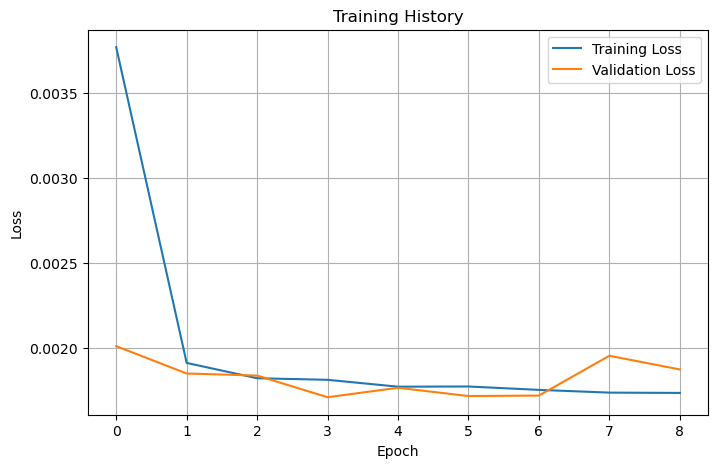

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

def compile_and_prepare_model(model, initial_learning_rate=1e-3):
    
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse',
        weighted_metrics=[]
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=1e-6,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop


my_model_ref=load_model(r'D:\Pycharm_conda_projects\NTU rul data analysis\NTU_rul_models\CCAE_models\0903_all_verify\0826_multiscale_CCAE_Base1024_VI.keras', compile=False)
my_model_V_in_I_out=my_model_ref
print("Model structures passed, start training...")

lr_scheduler_flux, early_stop_flux = compile_and_prepare_model(my_model_V_in_I_out)

with tf.device('/GPU:0'):
    print("開始訓練...")
    history_VI = my_model_V_in_I_out.fit(
        x=[past_voltages_normalized, torque_array, torque_array], 
        y=past_currents_normalized,
        batch_size=128,
        epochs=50,
        validation_split=0.1, 
        callbacks=[lr_scheduler_flux, early_stop_flux] 
    )

plt.figure(figsize=(8, 5))
plt.plot(history_VI.history['loss'], label='Training Loss')
if 'val_loss' in history_VI.history:
    plt.plot(history_VI.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

# save model 
my_model_V_in_I_out.save(os.path.join(rul_dataset_path, model_name + '.keras'))

metadata = {
    "model_name": model_name+'_VI_rul2',
    "sequence_length": sequence_length,
    "trained": True,
    "train_loss": history_VI.history['loss'][-1],
    "val_loss": history_VI.history.get('val_loss', [None])[-1],
    "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

with open(os.path.join(rul_dataset_path, model_name + '_VI_metadata_rul2.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)


II 模型

In [ ]:
# def compile_and_prepare_model(model, initial_learning_rate=1e-3):
    
#     model.compile(
#         optimizer=Adam(learning_rate=initial_learning_rate),
#         loss='mse',
#         weighted_metrics=[]
#     )

#     lr_scheduler = ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=5,
#         min_lr=1e-7,
#         verbose=1
#     )

#     early_stop = EarlyStopping(
#         monitor='val_loss',
#         patience=10,
#         min_delta=1e-6,
#         restore_best_weights=True,
#         verbose=1
#     )
#     return lr_scheduler, early_stop

# lr_scheduler_flux, early_stop_flux = compile_and_prepare_model(my_model_I_in_I_out_PEWC_rul2)

# # 測試模型結構是否正確 (無condition torque 為假輸入)
# my_model_I_in_I_out_PEWC_rul2.predict([ past_currents_normalized[0:1,:,:], torque_array[0:1,:], torque_array[0:1,:]])  
# #測試模型是否能夠正確讀取
# my_model_I_in_I_out_PEWC_rul2.save(os.path.join(model_path, model_name + '_II_rul2.keras'))
# my_model_I_in_I_out_PEWC_rul2= load_model(os.path.join(model_path, model_name + '_II_rul2.keras'))
# print("Model structures passed, start training...")

# print(past_currents_normalized.shape)
# with tf.device('/GPU:0'):
#     print("開始訓練...")
#     history_VI = my_model_I_in_I_out_PEWC_rul2.fit(
#         x=[past_currents_normalized, torque_array, torque_array], 
#         y=past_currents_normalized,
#         batch_size=128,
#         epochs=30,
#         validation_split=0.1, 
#         callbacks=[lr_scheduler_flux, early_stop_flux] 
#     )

# # save model 
# my_model_I_in_I_out_PEWC_rul2.save(os.path.join(model_path, model_name + '_II_rul2.keras'))

# metadata = {
#     "model_name": model_name+'_II_rul2',
#     "sequence_length": sequence_length,
#     "trained": True,
#     "train_loss": history_VI.history['loss'][-1],
#     "val_loss": history_VI.history.get('val_loss', [None])[-1],
#     "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
# }

# with open(os.path.join(model_path, model_name + '_II_metadata_rul2.json'), "w", encoding="utf-8") as f:
#     json.dump(metadata, f, ensure_ascii=False, indent=4)

# plt.figure(figsize=(8, 5))
# plt.plot(history_VI.history['loss'], label='Training Loss')
# if 'val_loss' in history_VI.history:
#     plt.plot(history_VI.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch') 
# plt.ylabel('Loss')
# plt.title('Training History')
# plt.legend()
# plt.grid(True)
# plt.show()


## Comparison ##
in time

1/1 [==============================] - 0s 367ms/step


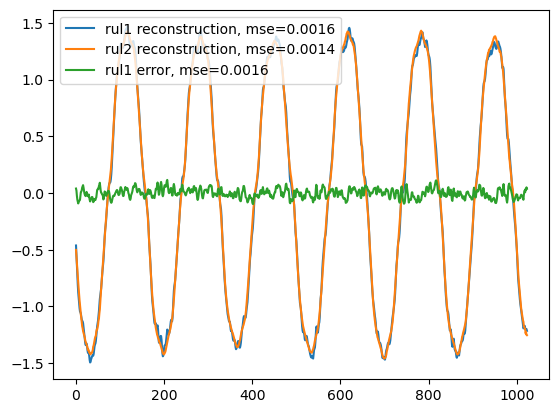

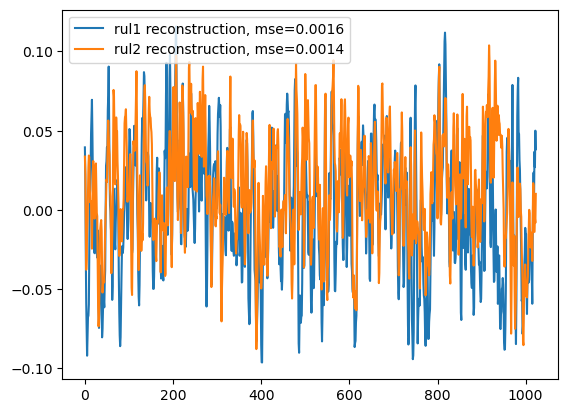

In [ ]:
# my_model_V_in_I_out_PEWC=load_model(os.path.join(model_path, model_name + '_VI.keras'))
# my_model_I_in_I_out_PEWC=load_model(os.path.join(model_path, model_name + '_II.keras'))
verify_results_rul_VI = my_model_V_in_I_out.predict([ past_voltages_normalized[0:1,:,:], torque_array[0:1,:]*0, torque_array[0:1,:]*0])  


# check the reconstruction VI vs II in rul2  
plt.figure()
errorsrul1=past_currents_normalized[0,:,0]-verify_results_rul_VI[0, :, 0]
errorsrul2=past_currents_normalized[0,:,1]-verify_results_rul_VI[0, :, 1]
plt.plot(past_currents_normalized[0,:,0], label=f'rul1 reconstruction, mse={np.mean(errorsrul1**2):.4f}')
plt.plot(verify_results_rul_VI[0,:,0], label=f'rul2 reconstruction, mse={np.mean(errorsrul2**2):.4f}')
plt.plot(errorsrul1, label=f'rul1 error, mse={np.mean(errorsrul1**2):.4f}')
plt.legend()

# check the reconstruction VI vs II in rul2  
plt.figure()
errorsrul1=past_currents_normalized[0,:,0]-verify_results_rul_VI[0, :, 0]
errorsrul2=past_currents_normalized[0,:,1]-verify_results_rul_VI[0, :, 1]
plt.plot(errorsrul1, label=f'rul1 reconstruction, mse={np.mean(errorsrul1**2):.4f}')
plt.plot(errorsrul2, label=f'rul2 reconstruction, mse={np.mean(errorsrul2**2):.4f}')
plt.legend()


計算與健康樣本的馬式距離

In [8]:
def get_augment_data_from_files_rul(files, augmen_sample_number=5):
    #進行資料增強
    train_signals=[] # vi signals alpha beta 
    train_signals_normalized=[]
    train_signals_normalized_byfile=[]
    torque_array=[]
                
    for file_path in files:
        if os.path.exists(file_path):
            # read the data
            df = read_rul_data(file_path)
            
            voltage_alpha= np.array(df["Voltage alpha downsample"]).squeeze()
            voltage_beta= np.array(df["Voltage beta downsample"]).squeeze()
            current_alpha= np.array(df["Current alpha downsample"]).squeeze()
            current_beta= np.array(df["Current beta downsample"]).squeeze()

            torque = (df["Torque avg"]) 
            
            temp_train_signals=[voltage_alpha, 
                                        voltage_beta,
                                        current_alpha,
                                        current_beta]
            
            temp_train_signals_normalized = []
            
            # 將數據標準化（均值為 0，標準差為 1）
            for signal in temp_train_signals:
                mean = np.mean(signal)
                std = np.std(signal)
                # 避免除以零的狀況（std == 0）
                if std == 0:
                    standardized = np.zeros_like(signal)
                else:
                    standardized = (signal - mean) / std
                temp_train_signals_normalized.append(standardized)
                    

            temp_train_signals = np.stack(temp_train_signals, axis=1)
            temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
            
            temp_train_input_signals_augmented = data_interval_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
            temp_train_signals_normalized_augmented = data_interval_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
            # 加入 train_input_signals
            train_signals.append(temp_train_input_signals_augmented)
            train_signals_normalized.append(temp_train_signals_normalized_augmented)
            torque_array.append(np.ones(augmen_sample_number) * torque)
            train_signals_normalized_byfile.append(temp_train_signals_normalized)
        else:
            print(f"File {file_path} does not exist.")
            
    train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
    train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
    torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)
    train_signals_normalized_byfile = np.array(train_signals_normalized_byfile, dtype=object)
    # 隨機打亂訓練資料
    # indices = np.random.permutation(train_signals.shape[0])
    # train_signals = train_signals[indices]
    train_input_signals = train_signals[:, :sequence_length, :]  # 取前 sequence_length 個
    # 正規化訓練資料
    # train_signals_normalized = train_signals_normalized[indices]
    train_input_signals_normalized = train_signals_normalized[:, :sequence_length, :]
    # torque_array = torque_array[indices]
    torque_array = torque_array.reshape(-1, 1)      # 將 torque_array 轉為 n, 1 batch 輸入狀態標籤

    # 訓練所需資料 (模型參考輸入)
    past_voltages=train_input_signals[:, :, 0:2]
    past_currents=train_input_signals[:, :, 2:4]
    # 正規畫資料
    past_voltages_normalized=train_input_signals_normalized[:, :, 0:2]
    past_currents_normalized=train_input_signals_normalized[:, :, 2:4] 
        # 將資料儲存到字典中
    # augment_data = {
    #     "input_signals": train_input_signals[:, :sequence_length, :],                         # 取前 sequence_length 個時間步長
    #     "input_signals_normalized": train_input_signals_normalized[:, :sequence_length, :],   # 取前 sequence_length 個時間步長
    #     "torque_array": torque_array
    # }
    return past_voltages_normalized, past_currents_normalized, torque_array, train_signals_normalized_byfile

def get_vibration_data(files):
    acc_rms_all=[]
                
    for file_path in files:
        if os.path.exists(file_path):
            # read the data
            df = read_rul_data(file_path)
            acc_rms = df["vibration rms"]
            acc_rms_all.append(acc_rms)
    acc_rms_all = np.concatenate(acc_rms_all, axis=0).astype(np.float32)
    return acc_rms_all


def mahalanobis_distance(xarray, yarray, mean, cov):
    """
    計算 (xarray, yarray) 每個點的馬氏距離

    參數
    ----
    xarray : array-like, shape (n,)
        x 座標
    yarray : array-like, shape (n,)
        y 座標
    mean : array-like, shape (2,)
        平均值向量 [mean_x, mean_y]
    cov : array-like, shape (2,2)
        共變異數矩陣

    回傳
    ----
    distances : ndarray, shape (n,)
        每個點的馬氏距離
    """
    xarray = np.asarray(xarray)
    yarray = np.asarray(yarray)
    mean = np.asarray(mean)
    cov = np.asarray(cov)

    # 計算 inverse covariance
    inv_cov = np.linalg.inv(cov)

    # 將 (x,y) 合併成樣本矩陣 shape=(n,2)
    points = np.column_stack((xarray, yarray))

    # 計算 Mahalanobis 距離 (向量化)
    diff = points - mean
    distances = np.sqrt(np.sum(diff @ inv_cov * diff, axis=1))
    return distances

def reconstruct_equal_interval(segments, original_length, sequence_length):
    """
    將等距切分後（並可能經 AE 重建）的片段，依原始切分規則拼回原始長度。

    參數
    ----
    segments : np.ndarray
        shape = (num_samples, sequence_length, d)
        每個片段（可已被 AE 重建）——形狀需與切分時一致。
    original_length : int
        原始訊號長度 N（例如 5000）。
    sequence_length : int
        當初切分時的視窗長度（例如 1024）。

    回傳
    ----
    reconstructed : np.ndarray
        shape = (original_length, d)
        還原後的完整序列；重疊區已做平均。
    """
    if sequence_length <= 0:
        raise ValueError("sequence_length 必須為正整數")

    num_samples, seq_len_chk, d = segments.shape
    if seq_len_chk != sequence_length:
        raise ValueError("segments 的第二維必須等於 sequence_length")

    if original_length < sequence_length:
        raise ValueError("original_length 必須 >= sequence_length")

    # 與切分函式一致的可切起點上限
    max_possible = original_length - sequence_length + 1

    if num_samples <= 0:
        raise ValueError("segments 的 num_samples 必須 > 0")
    if num_samples > max_possible:
        # 切回時也要守住上限（理論上不該發生；保險起見）
        raise ValueError("num_samples 超過當初可切的上限，請確認參數是否一致")

    # 產生等距起點（與 data_interval_augmentation 完全對齊）
    if num_samples == 1:
        start_indices = np.array([0], dtype=int)
    else:
        step = (max_possible - 1) / (num_samples - 1)
        start_indices = np.round(np.arange(num_samples) * step).astype(int)
        start_indices = np.clip(start_indices, 0, max_possible - 1)

    # 配置輸出與計數（用於重疊平均）
    reconstructed = np.zeros((original_length, d), dtype=segments.dtype)
    counts = np.zeros((original_length, 1), dtype=np.int32)

    # 貼回並累加
    for seg, start in zip(segments, start_indices):
        end = start + sequence_length
        reconstructed[start:end] += seg
        counts[start:end] += 1

    # 重疊區平均（避免除以 0）
    counts[counts == 0] = 1
    reconstructed = reconstructed / counts

    return reconstructed


# 導入所有資料並進行重建
start_file_idx=0
rul_Vdata_time, rul_Idata_time, rul_Torque_time, signals_normalized_byfile = get_augment_data_from_files_rul(rul2_files[start_file_idx:], augmen_sample_number=5)
reconstruction_rul_VI= my_model_V_in_I_out.predict([rul_Vdata_time,
                                                        rul_Torque_time,
                                                        rul_Torque_time], batch_size=512, verbose=1)


Unsupported file format: D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0722_1800_10p_1.0v_1_1\915_multiscale_CCAE_Base1024.keras


TypeError: 'NoneType' object is not subscriptable

In [10]:
def ema_along_time(x: np.ndarray, alpha: float = 0.1):
    """
    對每筆樣本 (N, T) 在時間維度 (axis=1) 做 EMA 平滑
    x: (N, T)
    """
    N, T = x.shape
    ema = np.zeros_like(x)
    ema[:, 0] = x[:, 0]

    for t in range(1, T):
        ema[:, t] = (1 - alpha) * ema[:, t-1] + alpha * x[:, t]

    return ema

rul_Idata_full_reconstructed=[]
# 以每 5 筆為單位進行處理
for i in range(0, rul_Vdata_time.shape[0], 5):
    reconstructed_I_batch = reconstruction_rul_VI[i:i+5]
    
    reconstructed = reconstruct_equal_interval(reconstructed_I_batch, original_length=5000, sequence_length=1024)

    rul_Idata_full_reconstructed.append(reconstructed)
    
rul_Idata_full_reconstructed = np.stack(rul_Idata_full_reconstructed)
rul_errors = (signals_normalized_byfile[:,:,2:4]  - rul_Idata_full_reconstructed[:,:,:]) ** 2
rul_errors[:,:,0]=ema_along_time(rul_errors[:,:,0], alpha=0.05)
rul_errors[:,:,1]=ema_along_time(rul_errors[:,:,1], alpha=0.05)
mean_errors_file = np.mean(np.sum(rul_errors, axis=-1), axis=-1)  # (B,)


rul_errors = (rul_Idata_time  - reconstruction_rul_VI) ** 2
rul_errors[:,:,0]=ema_along_time(rul_errors[:,:,0], alpha=0.05)
rul_errors[:,:,1]=ema_along_time(rul_errors[:,:,1], alpha=0.05)
mean_errors = np.mean(np.sum(rul_errors, axis=-1), axis=-1)  # (B,)
mean_errors_avg5 = np.mean(mean_errors.reshape(-1, 5), axis=1)



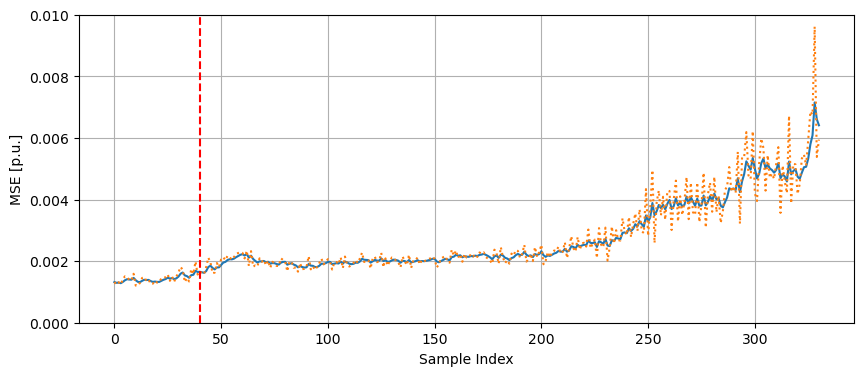

In [15]:
from scipy.signal import medfilt
from scipy.ndimage import uniform_filter1d, median_filter

def replace_outliers_with_medfilt(signal, kernel_size=3, threshold=0.002):
    """
    用中位數濾波檢測並替換訊號中的離群值
    
    參數:
        signal (array-like): 原始訊號
        kernel_size (int): 中位數濾波窗口大小 (必須是奇數)
        threshold (float): 判斷離群值的差異閾值
    
    回傳:
        np.ndarray: 補值後的訊號
    """
    signal = np.asarray(signal)
    
    # 中位數濾波
    filtered = medfilt(signal, kernel_size=kernel_size)
    
    # 找出離群點
    diff = np.abs(signal - filtered)
    mask = diff > threshold
    
    # 建立結果
    repaired = signal.copy()
    repaired[mask] = filtered[mask]
    
    return repaired


def repair_outliers_std(signal, window=11, n_sigma=2.0, fill_method='median'):
    """
    以移動平均/標準差偵測離群值，並依指定方式補齊。

    參數
    ----
    signal : array-like
        一維訊號
    window : int
        視窗長度（必須為正奇數）。視窗越大，統計越平滑。
    n_sigma : float
        判定離群值的 σ 倍數（例如 3 表示 3σ 準則）
    fill_method : {'median', 'mean', 'linear'}
        'median' : 用移動中位數補值（最抗尖峰）
        'mean'   : 用移動平均補值（較平滑）
        'linear' : 對離群點做線性插值（保持趨勢/相位）

    回傳
    ----
    repaired : np.ndarray
        補值後的訊號
    mask : np.ndarray[bool]
        True 表示原本被判定為離群的點
    mu : np.ndarray
        視窗移動平均
    sigma : np.ndarray
        視窗移動標準差
    """
    x = np.asarray(signal, dtype=float)
    if window <= 0 or window % 2 == 0:
        raise ValueError("window 必須為正奇數")
    if x.ndim != 1:
        raise ValueError("僅支援一維訊號")

    # 以 uniform_filter1d 快速計算移動平均與移動標準差（邊界使用 reflect）
    mu = uniform_filter1d(x, size=window, mode='reflect')
    mu2 = uniform_filter1d(x**2, size=window, mode='reflect')
    sigma = np.sqrt(np.clip(mu2 - mu**2, 0.0, None))

    # 以 n_sigma 判定離群
    mask = np.abs(x - mu) > n_sigma * (sigma + 1e-12)

    # 補值
    repaired = x.copy()
    if fill_method == 'median':
        med = median_filter(x, size=window, mode='reflect')
        repaired[mask] = med[mask]
    elif fill_method == 'mean':
        repaired[mask] = mu[mask]
    elif fill_method == 'linear':
        idx = np.arange(x.size)
        good = ~mask
        if good.any():
            repaired[mask] = np.interp(idx[mask], idx[good], x[good])
        # 若全部都是離群（極端情況），保留原值
    else:
        raise ValueError("fill_method 需為 'median'、'mean' 或 'linear'")

    return repaired, mask, mu, sigma

def smooth_moving_average(signal, window=5):
    """
    n 點視窗單位移動平均平滑 (simple moving average)

    參數
    ----
    signal : array-like
        一維訊號
    window : int
        視窗大小 (必須為正整數，建議 >= 3)

    回傳
    ----
    smoothed : np.ndarray
        平滑後的訊號
    """
    if window <= 0:
        raise ValueError("window 必須為正整數")
    x = np.asarray(signal, dtype=float)

    # 卷積計算移動平均
    kernel = np.ones(window) / window
    smoothed = np.convolve(x, kernel, mode='same')  # 'same' 保持輸出長度一致

    return smoothed


mean_errors_file_filt,_,_,_=repair_outliers_std(mean_errors_file, window=15)
mean_errors_avg5_filt,_,_,_=repair_outliers_std(mean_errors_avg5, window=15)

plt.figure(figsize=(10, 4))
plt.plot(ema_along_time(mean_errors_file_filt[None, :], alpha=0.3).squeeze(), linestyle='-', label='RUL2 MSE')
plt.plot(ema_along_time(mean_errors_file_filt[None, :], alpha=0.99).squeeze(), linestyle=':', label='RUL2 MSE')
# plt.plot(smooth_moving_average(mean_errors_file_filt, window=5), label='RUL2 MSE')
# plt.plot(ema_along_time(mean_errors_avg5_filt[None, :], alpha=0.3).squeeze(), label='RUL2 MSE')
plt.axvline(x=training_file_numbers, color='r', linestyle='--', label='Vertical Line at 500')
# plt.plot(rul2_mse_time[:,1], label='RUL2 MSE')
plt.xlabel('Sample Index')
plt.ylabel('MSE [p.u.]')
# plt.title('Reconstruction MSE for RUL5')
# plt.xlim(0, len(mean_errors_file_filt))
# plt.axis('tight')
# plt.xlim(0,300)
plt.ylim(0, 0.01)
# plt.legend()
plt.grid(True)
plt.savefig(r'TIE_plots\FFT_diff_Ialpha.svg', format='svg', bbox_inches='tight', transparent=False)
plt.savefig(os.path.join(rul_dataset_path, 'rul_reconstruction_MSE.svg'), format='svg', bbox_inches='tight', transparent=False)
plt.show()



'D:\\OneDrive\\RUL HI Reasearch Result\\Data_sets\\NTU_RUL_v2_data\\Acc_life_test_data\\Uncategorized_Data\\0722_1800_10p_1.0v_1_1'

多種組合

In [11]:
rul_data_pathes={
    "1200rpm":r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0718_1200_15p_1.0v_1",
    # "1800rpm_1":r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0722_1800_10p_1.0v_1_1",
    # "1800rpm_2":r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0722_1800_10p_1.0v_1_2",
    "1800rpm_all":r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0722_1800_10p_1.0v_1_all",
    "3000rpm":r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0710_3000_10_1.0v_3",
    
}

EVCC_rul_result = {}

for key in rul_data_pathes.keys():
    print(f"Processing dataset: {key}")
    rul_dataset_path=rul_data_pathes[key]
    rul_files = [f for f in os.listdir(rul_dataset_path) if f.endswith(".parquet") and os.path.isfile(os.path.join(rul_dataset_path, f))]
    # 將 rul_dataset_path 路徑加回 rul_files，得到完整路徑列表
    rul_files = [os.path.join(rul_dataset_path, f) for f in rul_files]
    rul_files = sorted(rul_files, key=extract_number)
    temp_model=load_model(os.path.join(rul_dataset_path, model_name + '.keras'), compile=False)
    
    print(rul_files[0:10])
    
    start_file_idx=0
    rul_Vdata_time, rul_Idata_time, rul_Torque_time, signals_normalized_byfile = get_augment_data_from_files_rul(rul_files[start_file_idx:], augmen_sample_number=5)
    reconstruction_rul_VI= temp_model.predict([rul_Vdata_time,
                                                            rul_Torque_time,
                                                            rul_Torque_time], batch_size=512, verbose=1)


    rul_Idata_full_reconstructed=[]
    # 以每 5 筆為單位進行處理
    for i in range(0, rul_Vdata_time.shape[0], 5):
        reconstructed_I_batch = reconstruction_rul_VI[i:i+5]
        
        reconstructed = reconstruct_equal_interval(reconstructed_I_batch, original_length=5000, sequence_length=1024)

        rul_Idata_full_reconstructed.append(reconstructed)
        
    # avg 5 method 
    rul_errors = (rul_Idata_time  - reconstruction_rul_VI) ** 2
    rul_errors[:,:,0]=ema_along_time(rul_errors[:,:,0], alpha=0.05)
    rul_errors[:,:,1]=ema_along_time(rul_errors[:,:,1], alpha=0.05)
    mean_errors = np.mean(np.sum(rul_errors, axis=-1), axis=-1)  # (B,)
    mean_errors_avg5 = np.mean(mean_errors.reshape(-1, 5), axis=1)
    
    # full reconstruct method
    rul_Idata_full_reconstructed = np.stack(rul_Idata_full_reconstructed)
    rul_errors = (signals_normalized_byfile[:,:,2:4]  - rul_Idata_full_reconstructed[:,:,:]) ** 2
    rul_errors[:,:,0]=ema_along_time(rul_errors[:,:,0], alpha=0.05)
    rul_errors[:,:,1]=ema_along_time(rul_errors[:,:,1], alpha=0.05)
    mean_errors_file = np.mean(np.sum(rul_errors, axis=-1), axis=-1)  # (B,)
    EVCC_rul_result[key] = {
            "mean_errors_avg5": mean_errors_avg5,
            "mean_errors_file": mean_errors_file
        }
    print(f"Finished processing dataset: {key}")
    


Processing dataset: 1200rpm
['D:\\OneDrive\\RUL HI Reasearch Result\\Data_sets\\NTU_RUL_v2_data\\Acc_life_test_data\\Uncategorized_Data\\0718_1200_15p_1.0v_1\\RUL_Data_3_1.parquet', 'D:\\OneDrive\\RUL HI Reasearch Result\\Data_sets\\NTU_RUL_v2_data\\Acc_life_test_data\\Uncategorized_Data\\0718_1200_15p_1.0v_1\\RUL_Data_3_2.parquet', 'D:\\OneDrive\\RUL HI Reasearch Result\\Data_sets\\NTU_RUL_v2_data\\Acc_life_test_data\\Uncategorized_Data\\0718_1200_15p_1.0v_1\\RUL_Data_3_3.parquet', 'D:\\OneDrive\\RUL HI Reasearch Result\\Data_sets\\NTU_RUL_v2_data\\Acc_life_test_data\\Uncategorized_Data\\0718_1200_15p_1.0v_1\\RUL_Data_3_4.parquet', 'D:\\OneDrive\\RUL HI Reasearch Result\\Data_sets\\NTU_RUL_v2_data\\Acc_life_test_data\\Uncategorized_Data\\0718_1200_15p_1.0v_1\\RUL_Data_3_5.parquet', 'D:\\OneDrive\\RUL HI Reasearch Result\\Data_sets\\NTU_RUL_v2_data\\Acc_life_test_data\\Uncategorized_Data\\0718_1200_15p_1.0v_1\\RUL_Data_3_6.parquet', 'D:\\OneDrive\\RUL HI Reasearch Result\\Data_sets\\NT

In [12]:
def get_vibration_data(files):
    acc_rms_all=[]
                
    for file_path in files:
        if os.path.exists(file_path):
            # read the data
            df = read_rul_data(file_path)
            acc_rms = df["vibration rms"]
            acc_rms_all.append(acc_rms)
    acc_rms_all = np.concatenate(acc_rms_all, axis=0).astype(np.float32)
    return acc_rms_all

for key in rul_data_pathes.keys():
    rul_dataset_path=rul_data_pathes[key]
    rul_files = [f for f in os.listdir(rul_dataset_path) if f.endswith(".parquet") and os.path.isfile(os.path.join(rul_dataset_path, f))]
    # 將 rul_dataset_path 路徑加回 rul_files，得到完整路徑列表
    rul_files = [os.path.join(rul_dataset_path, f) for f in rul_files]
    rul_files = sorted(rul_files, key=extract_number)
    acc_rms_all = get_vibration_data(rul_files)
    EVCC_rul_result[key]["vibration_rms"] = acc_rms_all
    print(f"Vibration data processed for dataset: {key}")
    

Vibration data processed for dataset: 1200rpm
Vibration data processed for dataset: 1800rpm_all
Vibration data processed for dataset: 3000rpm


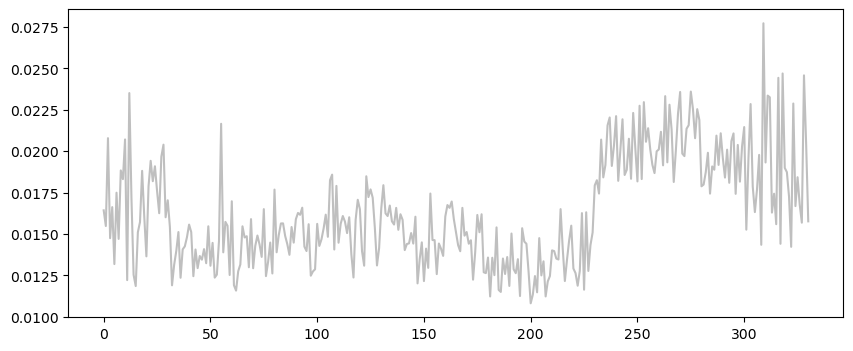

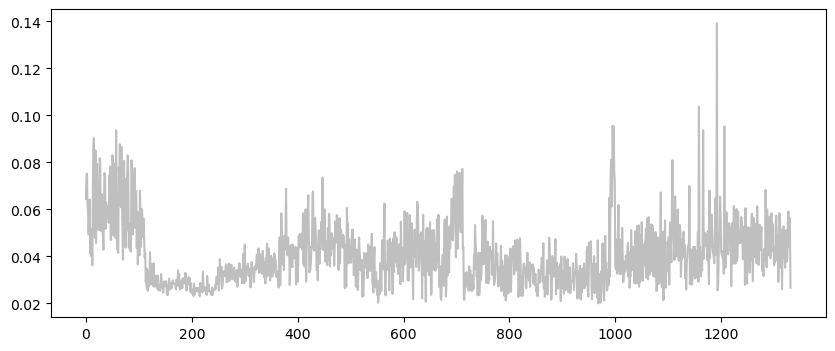

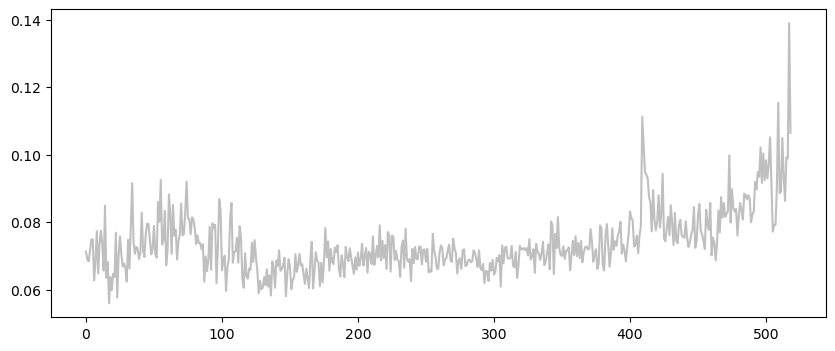

In [13]:
for key in rul_data_pathes.keys():
    plt.figure(figsize=(10, 4))
    plt.plot(EVCC_rul_result[key]["vibration_rms"], label='Vibration RMS', color='gray', alpha=0.5)
    plt.show()

Dataset: 1200rpm
(331,)
Crossing index for 1200rpm: 330, MSE: 0.004990
Dataset: 1800rpm_all
(1332,)
Crossing index for 1800rpm_all: 624, MSE: 0.006509
Dataset: 3000rpm
(519,)
Crossing index for 3000rpm: 414, MSE: 0.005839


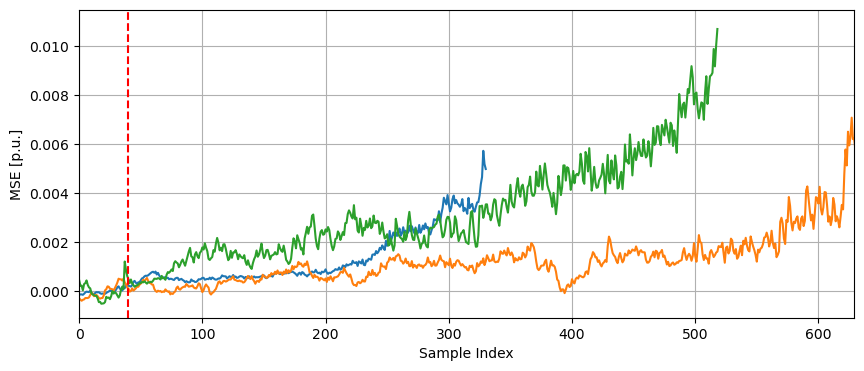

Dataset: 1200rpm
(331,)


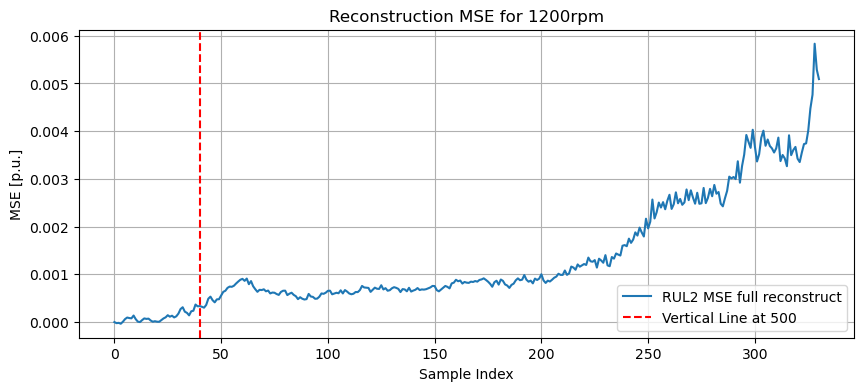

Dataset: 1800rpm_all
(1332,)


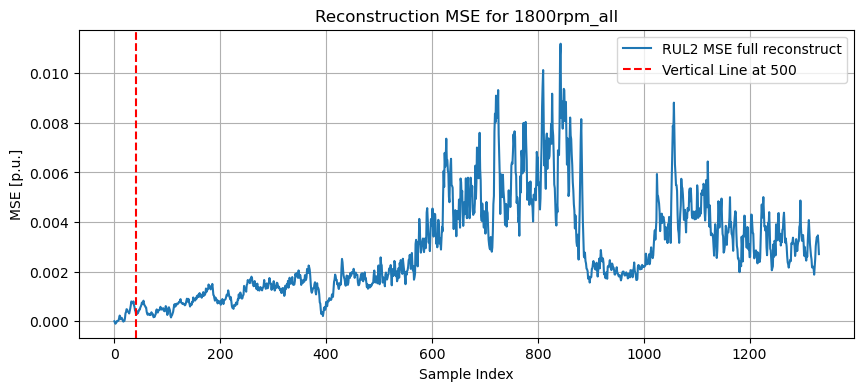

Dataset: 3000rpm
(519,)


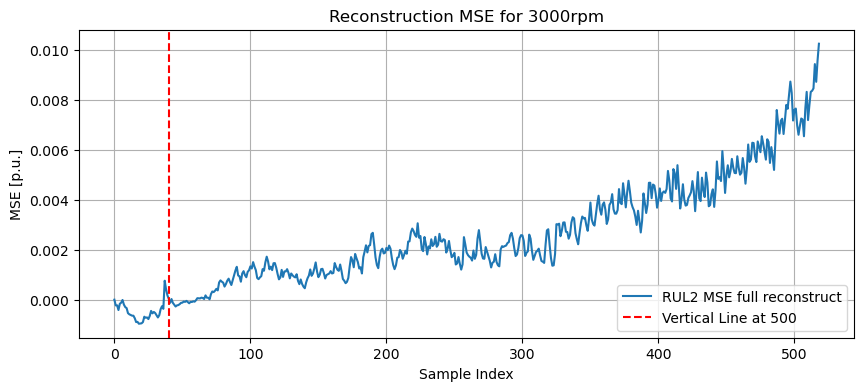

In [18]:
plt.close()
plt.figure(figsize=(10, 4))
max_rull_time=0
threshold = 0.0058
for key in EVCC_rul_result.keys():
    print(f"Dataset: {key}")
    mean_errors_avg5 = EVCC_rul_result[key]["mean_errors_avg5"]
    mean_errors_file = EVCC_rul_result[key]["mean_errors_file"]
    print(mean_errors_avg5.shape)
    mean_errors_file_filt,_,_,_=repair_outliers_std(mean_errors_file, window=15)
    mean_errors_avg5_filt,_,_,_=repair_outliers_std(mean_errors_avg5, window=15)
    ema_err=ema_along_time(mean_errors_file_filt[None, :], alpha=0.3).squeeze()
    ema_err=ema_err-np.mean(ema_err[0:training_file_numbers])
    crossing_idx = np.argmax(ema_err > threshold) if np.any(ema_err > threshold) else len(ema_err)-1
    max_rull_time=max(max_rull_time, crossing_idx)
    print(f"Crossing index for {key}: {crossing_idx}, MSE: {ema_err[crossing_idx]:.6f}")
    plt.plot(ema_err, label='RUL2 MSE full reconstruct')
    # plt.plot(ema_along_time(mean_errors_avg5_filt[None, :], alpha=0.3).squeeze(), label='RUL2 MSE avg5 method')
    
plt.axvline(x=training_file_numbers, color='r', linestyle='--', label='Vertical Line at 500')
# plt.axhline(y=threshold, color='r', linestyle='--', label='Horizontal Line at 0.0058')

plt.xlabel('Sample Index')
plt.ylabel('MSE [p.u.]')
# plt.ylim(-0.001, threshold+0.001)
plt.xlim(0, max_rull_time+5)
# plt.title(f'Reconstruction MSE for {key}')
# plt.legend()
plt.grid(True)
plt.show()



for key in EVCC_rul_result.keys():
    plt.figure(figsize=(10, 4))
    print(f"Dataset: {key}")
    mean_errors_avg5 = EVCC_rul_result[key]["mean_errors_avg5"]
    mean_errors_file = EVCC_rul_result[key]["mean_errors_file"]
    print(mean_errors_avg5.shape)
    mean_errors_file_filt,_,_,_=repair_outliers_std(mean_errors_file, window=15)
    mean_errors_avg5_filt,_,_,_=repair_outliers_std(mean_errors_avg5, window=15)
    ema_err=ema_along_time(mean_errors_file_filt[None, :], alpha=0.3).squeeze()
    plt.plot(ema_err-ema_err[0], label='RUL2 MSE full reconstruct')
    # plt.plot(ema_along_time(mean_errors_avg5_filt[None, :], alpha=0.3).squeeze(), label='RUL2 MSE avg5 method')
    
    plt.axvline(x=training_file_numbers, color='r', linestyle='--', label='Vertical Line at 500')
    plt.xlabel('Sample Index')
    plt.ylabel('MSE [p.u.]')
    # plt.ylim(0, 0.01)
    plt.title(f'Reconstruction MSE for {key}')
    plt.legend()
    plt.grid(True)
    plt.show()



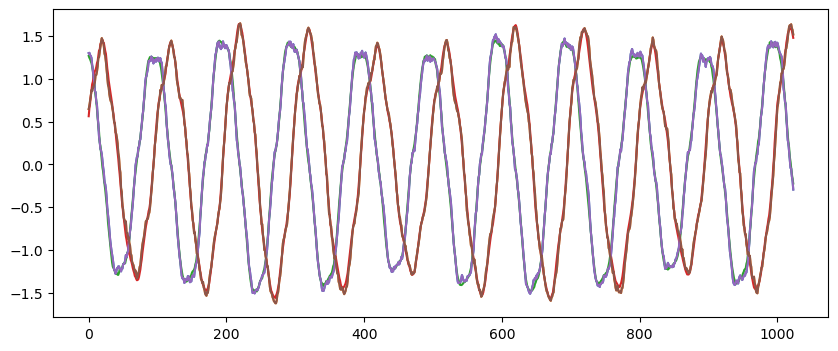

In [ ]:
plt.close()
plt.figure(figsize=(10, 4))
plt.plot(rul_Idata_time[0,:,:], label='RUL2 MSE')
plt.plot(reconstruction_rul_VI[0,:,:], label='RUL2 MSE')
plt.plot(signals_normalized_byfile[0,0:1024,2:4], label='RUL2 MSE')
plt.show()

以每五百筆資料為間隔進行重建避免記憶體爆炸

In [ ]:
import gc
# 參數

# 均勻切分函式 (驗證用)
def data_interval_augmentation(raw_data, sequence_length, augmen_sample_number, future_length):
    """
    以等距起點切分固定長度序列（不隨機），並可指定切分數量。
    
    raw_data: shape (n, d)
    sequence_length: 視窗長度（滑動窗大小）
    num_samples: 期望切分的樣本數（會自動上限為最大可切數）

    回傳:
        final_data: shape (num_samples_eff, sequence_length, d)
    """
    n = len(raw_data)
    if sequence_length <= 0:
        raise ValueError("sequence_length 必須為正整數")
    if n < sequence_length:
        raise ValueError("資料長度不足以切出任何序列樣本")
    if augmen_sample_number <= 0:
        raise ValueError("num_samples 必須為正整數")

    # 最大可切的起點數（= 可切的樣本上限）
    max_possible = n - sequence_length + 1

    # 若要求超過上限，截到上限
    num_samples_eff = min(augmen_sample_number, max_possible)

    # 等距產生起點（含 0 與 max_possible-1）
    if num_samples_eff == 1:
        start_indices = np.array([0], dtype=int)
    else:
        step = (max_possible - 1) / (num_samples_eff - 1)
        start_indices = np.round(np.arange(num_samples_eff) * step).astype(int)
        start_indices = np.clip(start_indices, 0, max_possible - 1)

    # 依起點切片
    samples_list = [raw_data[s:s + sequence_length] for s in start_indices]
    final_data = np.array(samples_list)

    return final_data

def get_augment_data_from_files_rul_interval(files, augmen_sample_number=5):
    #進行資料增強
    train_signals=[] # vi signals alpha beta 
    train_signals_normalized=[]
    torque_array=[]
                
    for file_path in files:
        if os.path.exists(file_path):
            # read the data
            df = read_rul_data_PEWC(file_path)
            
            df["Voltage beta"] = df["Voltage alpha"] / 2 - df["Voltage beta"] * np.sqrt(3) / 2 
            torque, _, _, v_alpha, v_beta, power_sts = estimate_torque(df, debug=False)

            voltage_alpha= np.array(df["Voltage alpha"]).squeeze()
            voltage_beta= np.array(df["Voltage beta"]).squeeze()
            current_alpha= np.array(df["Current alpha"]).squeeze()
            current_beta= np.array(df["Current beta"]).squeeze()

            
            if len(torque) > 2500:
                if len(torque) == 4000:
                    torque_avg = np.mean(np.abs(torque[-2000:]))
                else :
                    torque_avg = np.mean(np.abs(torque[2250:2500]))
            else:
                torque_avg = np.mean(np.abs(torque[-500:]))
            
            # 合併測試資料至訓練維度 shape=(,4000,dim)
            temp_train_signals=[voltage_alpha, 
                                        voltage_beta,
                                        current_alpha,
                                        current_beta]
            
            temp_train_signals_normalized = []
            
            # 將數據標準化（均值為 0，標準差為 1）
            for signal in temp_train_signals:
                mean = np.mean(signal)
                std = np.std(signal)
                # 避免除以零的狀況（std == 0）
                if std == 0:
                    standardized = np.zeros_like(signal)
                else:
                    standardized = (signal - mean) / std
                temp_train_signals_normalized.append(standardized)
                    

            temp_train_signals = np.stack(temp_train_signals, axis=1)
            temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
            
            temp_train_input_signals_augmented = data_interval_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
            temp_train_signals_normalized_augmented = data_interval_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
            # 加入 train_input_signals
            train_signals.append(temp_train_input_signals_augmented)
            train_signals_normalized.append(temp_train_signals_normalized_augmented)
            torque_array.append(np.ones(augmen_sample_number) * torque_avg)
            
        else:
            print(f"File {file_path} does not exist.")
            
    train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
    train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
    torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)

    # 隨機打亂訓練資料
    # indices = np.random.permutation(train_signals.shape[0])
    # train_signals = train_signals[indices]
    train_input_signals = train_signals[:, :sequence_length, :]  # 取前 sequence_length 個
    # 正規化訓練資料
    # train_signals_normalized = train_signals_normalized[indices]
    train_input_signals_normalized = train_signals_normalized[:, :sequence_length, :]
    # torque_array = torque_array[indices]
    torque_array = torque_array.reshape(-1, 1)      # 將 torque_array 轉為 n, 1 batch 輸入狀態標籤

    # 訓練所需資料 (模型參考輸入)
    past_voltages=train_input_signals[:, :, 0:2]
    past_currents=train_input_signals[:, :, 2:4]
    # 正規畫資料
    past_voltages_normalized=train_input_signals_normalized[:, :, 0:2]
    past_currents_normalized=train_input_signals_normalized[:, :, 2:4] 
        # 將資料儲存到字典中
    # augment_data = {
    #     "input_signals": train_input_signals[:, :sequence_length, :],                         # 取前 sequence_length 個時間步長
    #     "input_signals_normalized": train_input_signals_normalized[:, :sequence_length, :],   # 取前 sequence_length 個時間步長
    #     "torque_array": torque_array
    # }
    return past_voltages_normalized, past_currents_normalized, torque_array

# 前墜為訓練模型數據編號 後墜為套用模型編號
# 基於VI 模型的參考分布
ref_mean_VI_rul2, ref_cov_VI_rul2 = Guassian_2D_MLE(x_normal_VI_rul2, y_normal_VI_rul2)
ref_mean_VI_rul5, ref_cov_VI_rul5 = Guassian_2D_MLE(x_normal_VI_rul5, y_normal_VI_rul5)

# 基於II 模型的參考分布
ref_mean_II_rul2, ref_cov_II_rul2 = Guassian_2D_MLE(x_normal_II_rul2, y_normal_II_rul2)
ref_mean_II_rul5, ref_cov_II_rul5 = Guassian_2D_MLE(x_normal_II_rul5, y_normal_II_rul5)

chunk_size = 500
batch_size = 512  # 你原本的 predict batch size
MD_augmen_sample_number=5

start_file_idx=training_file_numbers
end_file_idx=len(rul5_files)
# 確保 end_file_idx 不會超過檔案數量
end_file_idx = min(end_file_idx, len(rul5_files))

rul5_mse_all_VI = []  # 用於累積每批的 MSE
rul5_mse_all_II = []  # 用於累積每批的 MSE
rul5_rul5_MD_VI = []
rul5_rul5_MD_II = []
rul5_torque = []

rul2_mse_all_VI = []  # 用於累積每批的 MSE
rul2_mse_all_II = []  # 用於累積每批的 MSE
rul2_rul2_MD_VI = []
rul2_rul2_MD_II = []
rul2_torque = []
start_file_idx=0

In [ ]:
print(f'process data from {start_file_idx} to {end_file_idx}...')

for batch_start in range(start_file_idx, end_file_idx, chunk_size):
    batch_end = min(batch_start + chunk_size, end_file_idx)
    files_batch = rul5_files[batch_start:batch_end]
    
    print(f'start file: {rul5_files[batch_start]}')
    # 1) 讀取/擴增這一批資料
    rul5_Vdata_time, rul5_Idata_time, rul5_Torque_time = get_augment_data_from_files_rul_interval(
        files_batch, augmen_sample_number=MD_augmen_sample_number
    )

    # 2) 推論
    reconstruction_rul5_VI = my_model_V_in_I_out_PEWC_rul5.predict(
        [rul5_Vdata_time, rul5_Torque_time, rul5_Torque_time],
        batch_size=batch_size,
        verbose=0
    )
    reconstruction_rul5_II = my_model_I_in_I_out_PEWC_rul5.predict(
        [rul5_Idata_time, rul5_Torque_time, rul5_Torque_time],
        batch_size=batch_size,
        verbose=0
    )

    # 3) 計算這一批的 MSE，並累積
    rul5_mse_time_VI = np.mean((rul5_Idata_time - reconstruction_rul5_VI) ** 2, axis=1)  # shape ~ (N_batch, 2)
    rul5_mse_all_VI.append(rul5_mse_time_VI)

    rul5_mse_time_II = np.mean((rul5_Idata_time - reconstruction_rul5_II) ** 2, axis=1)  # shape ~ (N_batch, 2)
    rul5_mse_all_II.append(rul5_mse_time_II)

    # Mahalanobis distance + 每 MD_augmen_sample_number 筆取平均
    MSE_distances_VI_rul5 = mahalanobis_distance(
        rul5_mse_time_VI[:, 0], rul5_mse_time_VI[:, 1], ref_mean_VI_rul5, ref_cov_VI_rul5
    )
    
    MSE_distances_II_rul5 = mahalanobis_distance(
        rul5_mse_time_II[:, 0], rul5_mse_time_II[:, 1], ref_mean_II_rul5, ref_cov_II_rul5
    )
     
    # 對齊長度再重塑
    usable_len = (len(MSE_distances_VI_rul5) // MD_augmen_sample_number) * MD_augmen_sample_number
    MSE_distances_avg_VI_rul5 = np.mean(
        MSE_distances_VI_rul5[:usable_len].reshape(-1, MD_augmen_sample_number), axis=1
    )

    usable_len = (len(MSE_distances_II_rul5) // MD_augmen_sample_number) * MD_augmen_sample_number
    MSE_distances_avg_II_rul5 = np.mean(
        MSE_distances_II_rul5[:usable_len].reshape(-1, MD_augmen_sample_number), axis=1
    )
    
    rul5_Torque_time_avg = np.mean(
        rul5_Torque_time[:usable_len].reshape(-1, MD_augmen_sample_number), axis=1
    )

    rul5_rul5_MD_VI.append(MSE_distances_avg_VI_rul5)
    rul5_rul5_MD_II.append(MSE_distances_avg_II_rul5)
    rul5_torque.append(rul5_Torque_time_avg)

    print(f'Processed rul5 files from index {batch_start} to {batch_end}, MSE shape: {rul5_mse_time_VI.shape}')
    # 4) 釋放記憶體
    del rul5_Vdata_time, rul5_Idata_time, rul5_Torque_time, reconstruction_rul5_VI, rul5_mse_time_VI, rul5_mse_time_II
    gc.collect()


process data from 0 to 17967...
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_2754.parquet
Processed rul5 files from index 0 to 500, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_3254.parquet
Processed rul5 files from index 500 to 1000, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_3754.parquet
Processed rul5 files from index 1000 to 1500, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_4254.parquet
Processed rul5 files from index 1500 to 2000, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_4754.parquet
Processed rul5 files from index 2000 to 2500, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data 

In [ ]:
print(f'process data from {start_file_idx} to {end_file_idx}...')

for batch_start in range(start_file_idx, end_file_idx, chunk_size):
    batch_end = min(batch_start + chunk_size, end_file_idx)
    files_batch = rul2_files[batch_start:batch_end]

    print(f'start file: {rul2_files[batch_start]}')
    
    # 1) 讀取/擴增這一批資料
    rul2_Vdata_time, rul2_Idata_time, rul2_Torque_time = get_augment_data_from_files_rul_interval(
        files_batch, augmen_sample_number=MD_augmen_sample_number
    )

    # 2) 推論
    reconstruction_rul2_VI = my_model_V_in_I_out_PEWC_rul2.predict(
        [rul2_Vdata_time, rul2_Torque_time, rul2_Torque_time],
        batch_size=batch_size,
        verbose=0
    )
    reconstruction_rul2_II = my_model_I_in_I_out_PEWC_rul2.predict(
        [rul2_Idata_time, rul2_Torque_time, rul2_Torque_time],
        batch_size=batch_size,
        verbose=0
    )

    # 3) 計算這一批的 MSE，並累積
    rul2_mse_time_VI = np.mean((rul2_Idata_time - reconstruction_rul2_VI) ** 2, axis=1)  # shape ~ (N_batch, 2)
    rul2_mse_all_VI.append(rul2_mse_time_VI)

    rul2_mse_time_II = np.mean((rul2_Idata_time - reconstruction_rul2_II) ** 2, axis=1)  # shape ~ (N_batch, 2)
    rul2_mse_all_II.append(rul2_mse_time_II)

    # Mahalanobis distance + 每 MD_augmen_sample_number 筆取平均
    MSE_distances_VI_rul2 = mahalanobis_distance(
        rul2_mse_time_VI[:, 0], rul2_mse_time_VI[:, 1], ref_mean_VI_rul2, ref_cov_VI_rul2
    )

    MSE_distances_II_rul2 = mahalanobis_distance(
        rul2_mse_time_II[:, 0], rul2_mse_time_II[:, 1], ref_mean_II_rul2, ref_cov_II_rul2
    )
     
    # 對齊長度再重塑
    usable_len = (len(MSE_distances_VI_rul2) // MD_augmen_sample_number) * MD_augmen_sample_number
    MSE_distances_avg_VI_rul2 = np.mean(
        MSE_distances_VI_rul2[:usable_len].reshape(-1, MD_augmen_sample_number), axis=1
    )

    usable_len = (len(MSE_distances_II_rul2) // MD_augmen_sample_number) * MD_augmen_sample_number
    MSE_distances_avg_II_rul2 = np.mean(
        MSE_distances_II_rul2[:usable_len].reshape(-1, MD_augmen_sample_number), axis=1
    )

    rul2_Torque_time_avg = np.mean(
        rul2_Torque_time[:usable_len].reshape(-1, MD_augmen_sample_number), axis=1
    )

    rul2_rul2_MD_VI.append(MSE_distances_avg_VI_rul2)
    rul2_rul2_MD_II.append(MSE_distances_avg_II_rul2)
    rul2_torque.append(rul2_Torque_time_avg)

    print(f'Processed rul2 files from index {batch_start} to {batch_end}, MSE shape: {rul2_mse_time_VI.shape}')

    # 4) 釋放記憶體
    del rul2_Vdata_time, rul2_Idata_time, rul2_Torque_time, reconstruction_rul2_VI, rul2_mse_time_VI, rul2_mse_time_II
    gc.collect()


process data from 0 to 17967...
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_2\RUL_Data_2_2754.parquet
Processed rul2 files from index 0 to 500, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_2\RUL_Data_2_3254.parquet
Processed rul2 files from index 500 to 1000, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_2\RUL_Data_2_3754.parquet
Processed rul2 files from index 1000 to 1500, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_2\RUL_Data_2_4254.parquet
Processed rul2 files from index 1500 to 2000, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_2\RUL_Data_2_4754.parquet
Processed rul2 files from index 2000 to 2500, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data 

In [ ]:
import pandas as pd
import datetime
def exponential_smoothing(series, alpha):
    smoothed = np.zeros_like(series)
    smoothed[0] = series[0]
    for t in range(1, len(series)):
        smoothed[t] = alpha * series[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# rul5_MD = np.concatenate(rul5_rul5_MD)
torque_array_rul5 = np.concatenate(rul5_torque)
torque_array_rul2 = np.concatenate(rul2_torque)
print(len(torque_array_rul5))
print(len(torque_array_rul2))

# 取出大於20的idx並將其去除
# rul2 
rul5_MD_VI = np.concatenate(rul5_rul5_MD_VI)
idx_valid_rul5 = np.where(rul5_MD_VI <= 20)[0]
rul5_MD_VI_filtered = rul5_MD_VI[idx_valid_rul5]
rul5_MD_II_filtered = np.concatenate(rul5_rul5_MD_II)[idx_valid_rul5]
torque_array_rul5_filtered = torque_array_rul5[idx_valid_rul5]

# rul2
rul2_MD_VI = np.concatenate(rul2_rul2_MD_VI)
idx_valid_rul2 = np.where(rul2_MD_VI <= 20)[0]
rul2_MD_VI_filtered = rul2_MD_VI[idx_valid_rul2]
rul2_MD_II_filtered = np.concatenate(rul2_rul2_MD_II)[idx_valid_rul2]
torque_array_rul2_filtered = torque_array_rul2[idx_valid_rul2]



alpha=0.1
# 繪圖
check_start=300
check_end=13000
df_start=read_rul_data_PEWC(rul5_files[check_start])
df_end=read_rul_data_PEWC(rul5_files[check_end])

fig, ax = plt.subplots(figsize=(8, 4))

# 繪圖
ax.plot(exponential_smoothing((rul5_MD_II_filtered)[check_start:check_end], alpha=alpha), label='RUL5 MD II', linewidth=1)
ax.plot(exponential_smoothing((rul2_MD_VI_filtered)[check_start:check_end], alpha=alpha), label='RUL5 MD VI', linewidth=1)
ax.plot(exponential_smoothing((rul2_MD_II_filtered)[check_start:check_end], alpha=alpha), label='RUL2 MD II', linewidth=1)
ax.plot(exponential_smoothing((rul5_MD_VI_filtered)[check_start:check_end], alpha=alpha), label='RUL2 MD VI', linewidth=1)

ax.set_xlabel('Sample index')
ax.set_ylabel('Anomaly Scores')

# 轉換開始與結束時間
start_time_dt = datetime.datetime.fromtimestamp(float(df_start['Unix Time']))
end_time_dt = datetime.datetime.fromtimestamp(float(df_end['Unix Time']))

# 在 x 軸刻度標籤的正下方標註日期
ax.text(0, -0.15, start_time_dt.strftime('%Y-%m-%d'),
        ha='center', va='top', transform=ax.get_xaxis_transform())
ax.text(check_end - check_start - 1, -0.15, end_time_dt.strftime('%Y-%m-%d'),
        ha='center', va='top', transform=ax.get_xaxis_transform())

# ax.legend()
ax.grid(True)
ax.set_ylim(0, 15)  # 設定 y 軸範圍
plt.savefig(os.path.join('TIE_plots','PEWC_EVCC.png'), dpi=300, bbox_inches='tight')
plt.show()



check_start=11500
check_end=13000
fig, ax = plt.subplots(figsize=(8, 4))

# zoom in 
ax.plot(range(check_start, check_end),exponential_smoothing( (rul5_MD_II_filtered)[check_start:check_end], alpha=alpha), label='RUL5 MD II', linewidth=1)
ax.plot(range(check_start, check_end),exponential_smoothing( (rul2_MD_VI_filtered)[check_start:check_end], alpha=alpha), label='RUL5 MD VI', linewidth=1)
ax.plot(range(check_start, check_end),exponential_smoothing( (rul2_MD_II_filtered)[check_start:check_end], alpha=alpha), label='RUL2 MD II', linewidth=1)
ax.plot(range(check_start, check_end),exponential_smoothing( (rul5_MD_VI_filtered)[check_start:check_end], alpha=alpha), label='RUL2 MD VI', linewidth=1)

ax.grid(True)
ax.set_ylim(0, 10)  # 設定 y 軸範圍
plt.savefig(os.path.join('TIE_plots','PEWC_EVCC_zoomin.png'), dpi=300, bbox_inches='tight')
plt.show()



plt.figure(figsize=(10, 4))
plt.plot(np.concatenate(rul2_torque), label='Torque')
plt.xlabel('Sample Index')
plt.ylabel('Torque')
plt.title('Reconstruction Torque for RUL2 (chunked by 500)')
plt.legend()
plt.grid(True)
plt.ylim(200, 250)  # 設定 y 軸範圍
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(torque_array_rul5, label='Torque')
plt.xlabel('Sample Index')
plt.ylabel('Torque')
plt.title('Reconstruction Torque for RUL5 (chunked by 500)')
plt.legend()
plt.grid(True)
plt.ylim(180, 210)  # 設定 y 軸範圍
plt.show()
df_check=read_rul_data_PEWC(rul5_files[12250])
print(datetime.datetime.fromtimestamp(float(df_check['Unix Time'])))

NameError: name 'np' is not defined

: 

In [ ]:
# print(rul5_mse_all.shape)
def exponential_smoothing(series, alpha):
    smoothed = np.zeros_like(series)
    smoothed[0] = series[0]
    for t in range(1, len(series)):
        smoothed[t] = alpha * series[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# smoothed_first_col = exponential_smoothing(rul5_mse_all[:,0], 0.1)
# smoothed_second_col = exponential_smoothing(rul5_mse_all[:,1], 0.1)
# # 繪圖
# plt.figure(figsize=(10, 4))
# plt.plot(smoothed_first_col, label='RUL5 MSE (Voltage)')
# plt.plot(smoothed_second_col, label='RUL5 MSE (Current)')
# plt.xlabel('Sample Index')
# plt.ylabel('MSE')
# plt.title('Reconstruction MSE for RUL5 (chunked by 500)')
# plt.ylim(0, 0.013)  # 設定 y 軸範圍
# plt.legend()
# plt.grid(True)
# plt.show()
# plt.close()

# check_idx_start=60000
# check_idx_end=80000
# # 繪圖
# plt.figure(figsize=(10, 4))
# plt.plot(smoothed_first_col[check_idx_start:check_idx_end], label='RUL5 MSE (Voltage)')
# plt.plot(smoothed_second_col[check_idx_start:check_idx_end], label='RUL5 MSE (Current)')
# plt.xlabel('Sample Index')
# plt.ylabel('MSE')
# plt.title('Reconstruction MSE for RUL5 (chunked by 500)')
# plt.ylim(0, 0.013)  # 設定 y 軸範圍
# plt.legend()
# plt.grid(True)
# plt.show()
# plt.close()


check_idx_start=12500
check_idx_end=17500
# 繪圖
plt.figure(figsize=(10, 4))
plt.plot(rul5_MD[check_idx_start:check_idx_end], label='RUL5 MD')
plt.plot( exponential_smoothing(rul5_MD[check_idx_start:check_idx_end], 0.01))
plt.xlabel('Sample Index')
plt.ylabel('MD')
plt.title('Reconstruction MD for RUL5 (chunked by 500)')
plt.ylim(25, 55)  # 設定 y 軸範圍
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(10, 4))
plt.plot(rul2_MD_np[check_idx_start:check_idx_end], label='RUL2 MD')
plt.plot( exponential_smoothing(rul2_MD_np[check_idx_start:check_idx_end], 0.1))
plt.xlabel('Sample Index')
plt.ylabel('MD')
plt.title('Reconstruction MD for RUL2 (chunked by 500)')
plt.ylim(0, 10)  # 設定 y 軸範圍
plt.legend()
plt.grid(True)
plt.show() 



NameError: name 'rul5_MD' is not defined

<Figure size 1000x400 with 0 Axes>

雙軸電流誤差計算

In [ ]:
len(torque_array)

48000

In [ ]:
# 計算重建殘差
# 以 one_test_batch_files 個檔案維一個資料集分析變化

# 儲存重建誤差值
reconstruction_errs_batches_ab = [] # 以batch 儲存重建誤差原始值(每一元素為該批次資料之原始重建誤差)
reconstruction_mse_batches_ab=[]# 儲存重建誤差mse(每一點為該批次資料之mse)
for start_idx in range(0, test_input_augmented.shape[0], data_per_test_bartch):
    end_idx=start_idx + data_per_test_bartch
    reconstruc_err_per_batch_alpha=test_input_augmented[start_idx:end_idx,:,0:1] - (test_results[0][start_idx:end_idx,:])
    reconstruc_err_per_batch_beta=test_input_augmented[start_idx:end_idx,:,1:2] - (test_results[1][start_idx:end_idx,:])
    reconstruc_err_per_batch = np.concatenate((reconstruc_err_per_batch_alpha, reconstruc_err_per_batch_beta), axis=1)
    reconstruction_errs_batches_ab.append(reconstruc_err_per_batch)
    
    # 將批次誤差一維化並聚攏，方便計算最終mse值
    flattened_batch_err= np.array(reconstruc_err_per_batch).flatten()
    reconstruction_mse_batches_ab.append(np.mean(np.square(flattened_batch_err)))

NameError: name 'test_input_augmented' is not defined

Text(0, 0.5, 'Error')

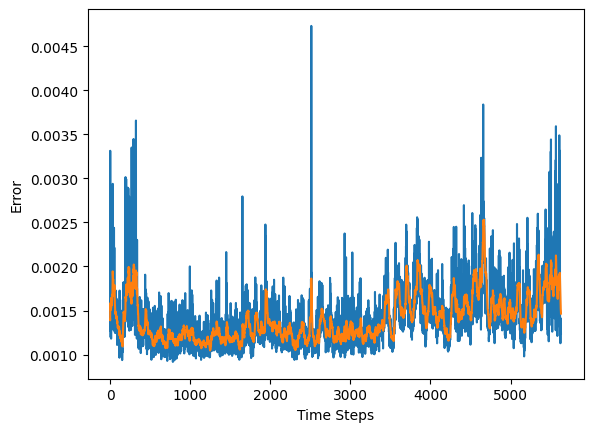

In [ ]:

# 對 reconstruction_mse_batches_ab 做指數平滑
def exponential_smoothing(data, alpha=0.1):
    smoothed = [data[0]]
    for v in data[1:]:
        smoothed.append(alpha * v + (1 - alpha) * smoothed[-1])
    return smoothed

reconstruction_mse_batches_ab_smooth = exponential_smoothing(reconstruction_mse_batches_ab, alpha=0.1)
# # 繪製重建殘差
plt.figure()

plt.plot( reconstruction_mse_batches_ab, label='Reconstruction Error')
plt.plot( reconstruction_mse_batches_ab_smooth, label='Reconstruction Error')
plt.xlabel('Time Steps')
plt.ylabel('Error')

Save the prediction result

In [ ]:
import pickle
from datetime import datetime

epochs=10
batch_size=100

model_type = 'I2_in_I2_out'

prediction_results = {
    "Model_type": model_type,
    "Model_name": model_save_name,
    "Input_type": "alpha_beta",
    "Output_type": "alpha_beta",
    "Training_info": {
        "epochs": epochs,
        "batch_size": batch_size,
        "optimizer": "adam",
        "loss": "mse",
    },
    "Evaluation": {
        "reconstruction_errs_batches_alpha": reconstruction_errs_batches_ab,
        "reconstruction_mse_batches": reconstruction_mse_batches_ab,
    },
    "Timestamps": {
        "saved_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
}

result_save_path=os.path.join(model_saved_path, f"{model_type}_results.pkl")
with open(result_save_path, "wb") as f:
    pickle.dump(prediction_results, f)


NameError: name 'model_save_name' is not defined